In [1]:
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

# Reading files

In [4]:
files = glob("*.csv")
def read_spectrum(path):
    with open(path, "r") as f:
        unf_file = [values for values in f.readlines() if values.startswith("SPCH")]
        frm_file = np.array([values.strip("SPCH 131 0 0 1234 spectre_type{5} ").split() for values in unf_file ], dtype=np.float32)
    return frm_file


In [5]:
k_spec = np.sum(read_spectrum(files[0]), axis=0)
q_spec = read_spectrum(files[1]) # if this gives a numpy error, its because last line has 1023 elements. Add a 0 in the last row
th_spec = np.sum(read_spectrum(files[2]), axis=0)
u_spec = np.sum(read_spectrum(files[3]), axis=0)

# Visualisation

C:\Users\Алексей\AppData\Local\Temp\ipykernel_24656\1780337425.py:4: RuntimeWarning: divide by zero encountered in log
  ax.plot(channel, np.log(k_spec), label="Potassium spectrum")
C:\Users\Алексей\AppData\Local\Temp\ipykernel_24656\1780337425.py:5: RuntimeWarning: divide by zero encountered in log
  ax.plot(channel, np.log(u_spec), label="Uranium spectrum")
C:\Users\Алексей\AppData\Local\Temp\ipykernel_24656\1780337425.py:6: RuntimeWarning: divide by zero encountered in log
  ax.plot(channel, np.log(th_spec), label="Thorium spectrum")
C:\Users\Алексей\AppData\Local\Temp\ipykernel_24656\1780337425.py:7: RuntimeWarning: divide by zero encountered in log
  ax.plot(channel, np.log(q_spec[0]), label="measured spectrum")


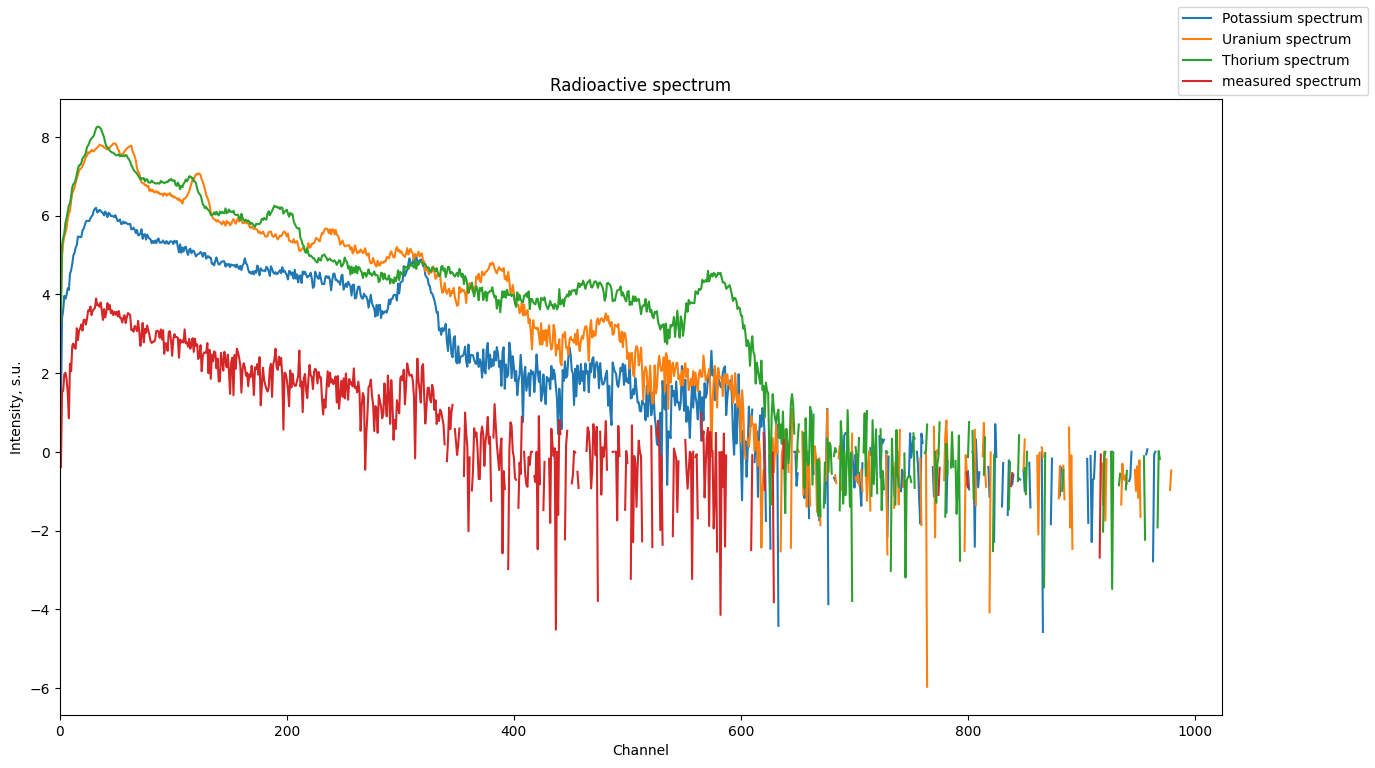

In [10]:
# There is an issue when taking log of 0 values. Adding small epsilon worsens the ovarall quality of plot. Just ignoring for now
fig, ax = plt.subplots(figsize=(15, 8))
channel = np.arange(1,1025,1)
ax.plot(channel, np.log(k_spec), label="Potassium spectrum")
ax.plot(channel, np.log(u_spec), label="Uranium spectrum")
ax.plot(channel, np.log(th_spec), label="Thorium spectrum")
ax.plot(channel, np.log(q_spec[0]), label="measured spectrum")
ax.set_title("Radioactive spectrum")
ax.set_xlabel("Channel")
ax.set_ylabel("Intensity, s.u.")
ax.set_xlim(0, 1024)
fig.legend()

# LS computation

We will use the least squares method to find the answer to this matrix equation $S*C=\Omega$. 
The equation we are solving is $C=(S^TS)^{-1}(S^T\Omega)$

In [11]:
S = np.vstack((k_spec, u_spec, th_spec)).T
conc, _, _, _ = np.linalg.lstsq(S, q_spec.T)


C:\Users\Алексей\AppData\Local\Temp\ipykernel_24656\1401008359.py:2: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  conc, _, _, _ = np.linalg.lstsq(S, q_spec.T)


## Concentration visualisation

In [12]:
sigma = np.sqrt(np.sum((q_spec.T - S @ conc)**2, axis=0)/(q_spec.shape[1]-3))
sigma.mean()

3.0339026

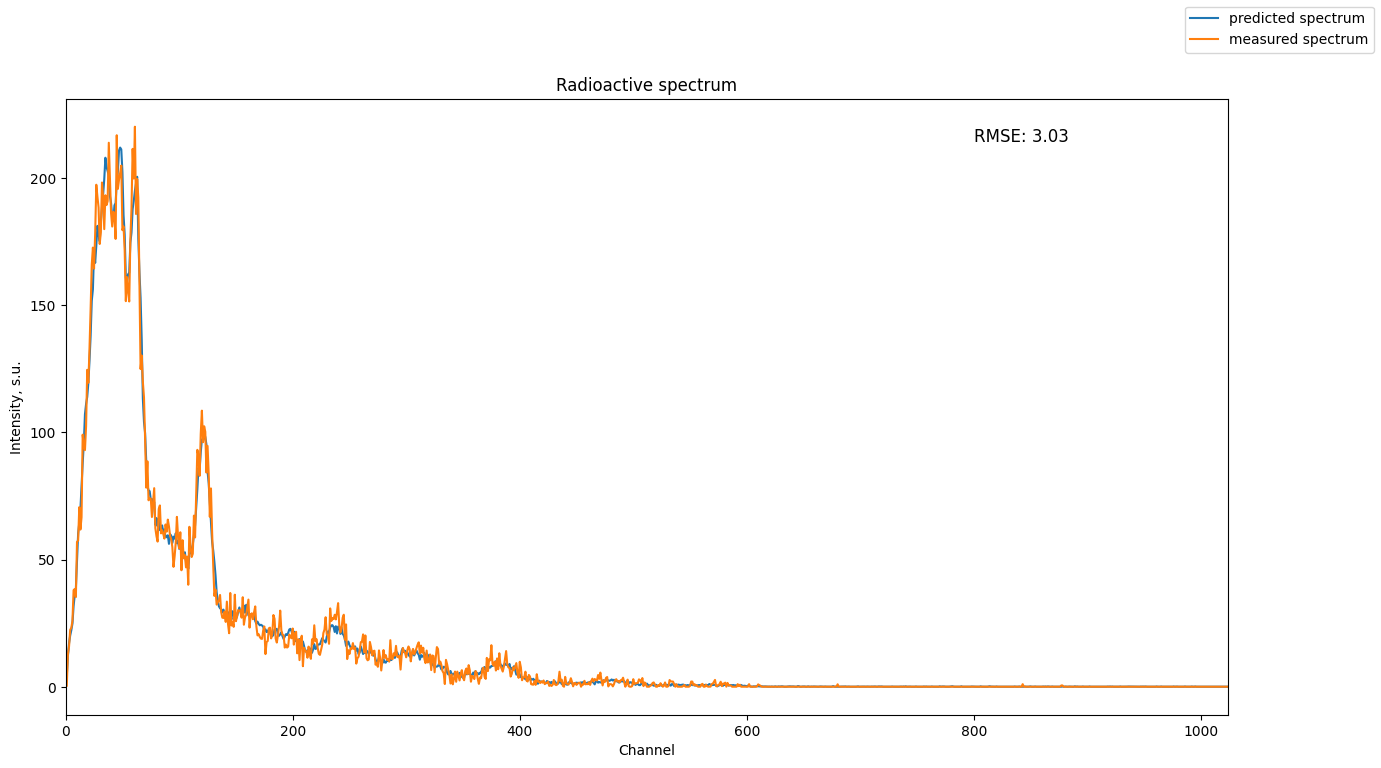

In [14]:
# Визуализация полученного спекта
pred = (S @ conc).T

fig, ax = plt.subplots(figsize=(15, 8))
channel = np.arange(1,1025,1)
interval = 3
ax.plot(channel, pred[interval], label="predicted spectrum")
ax.plot(channel, q_spec[interval], label="measured spectrum")
ax.set_title("Radioactive spectrum")
ax.set_xlabel("Channel")
ax.set_ylabel("Intensity, s.u.")
ax.set_xlim(0, 1024)
ax.text(800, 220, f'RMSE: {sigma.mean():.2f}', fontsize=12, verticalalignment='top')
fig.legend()

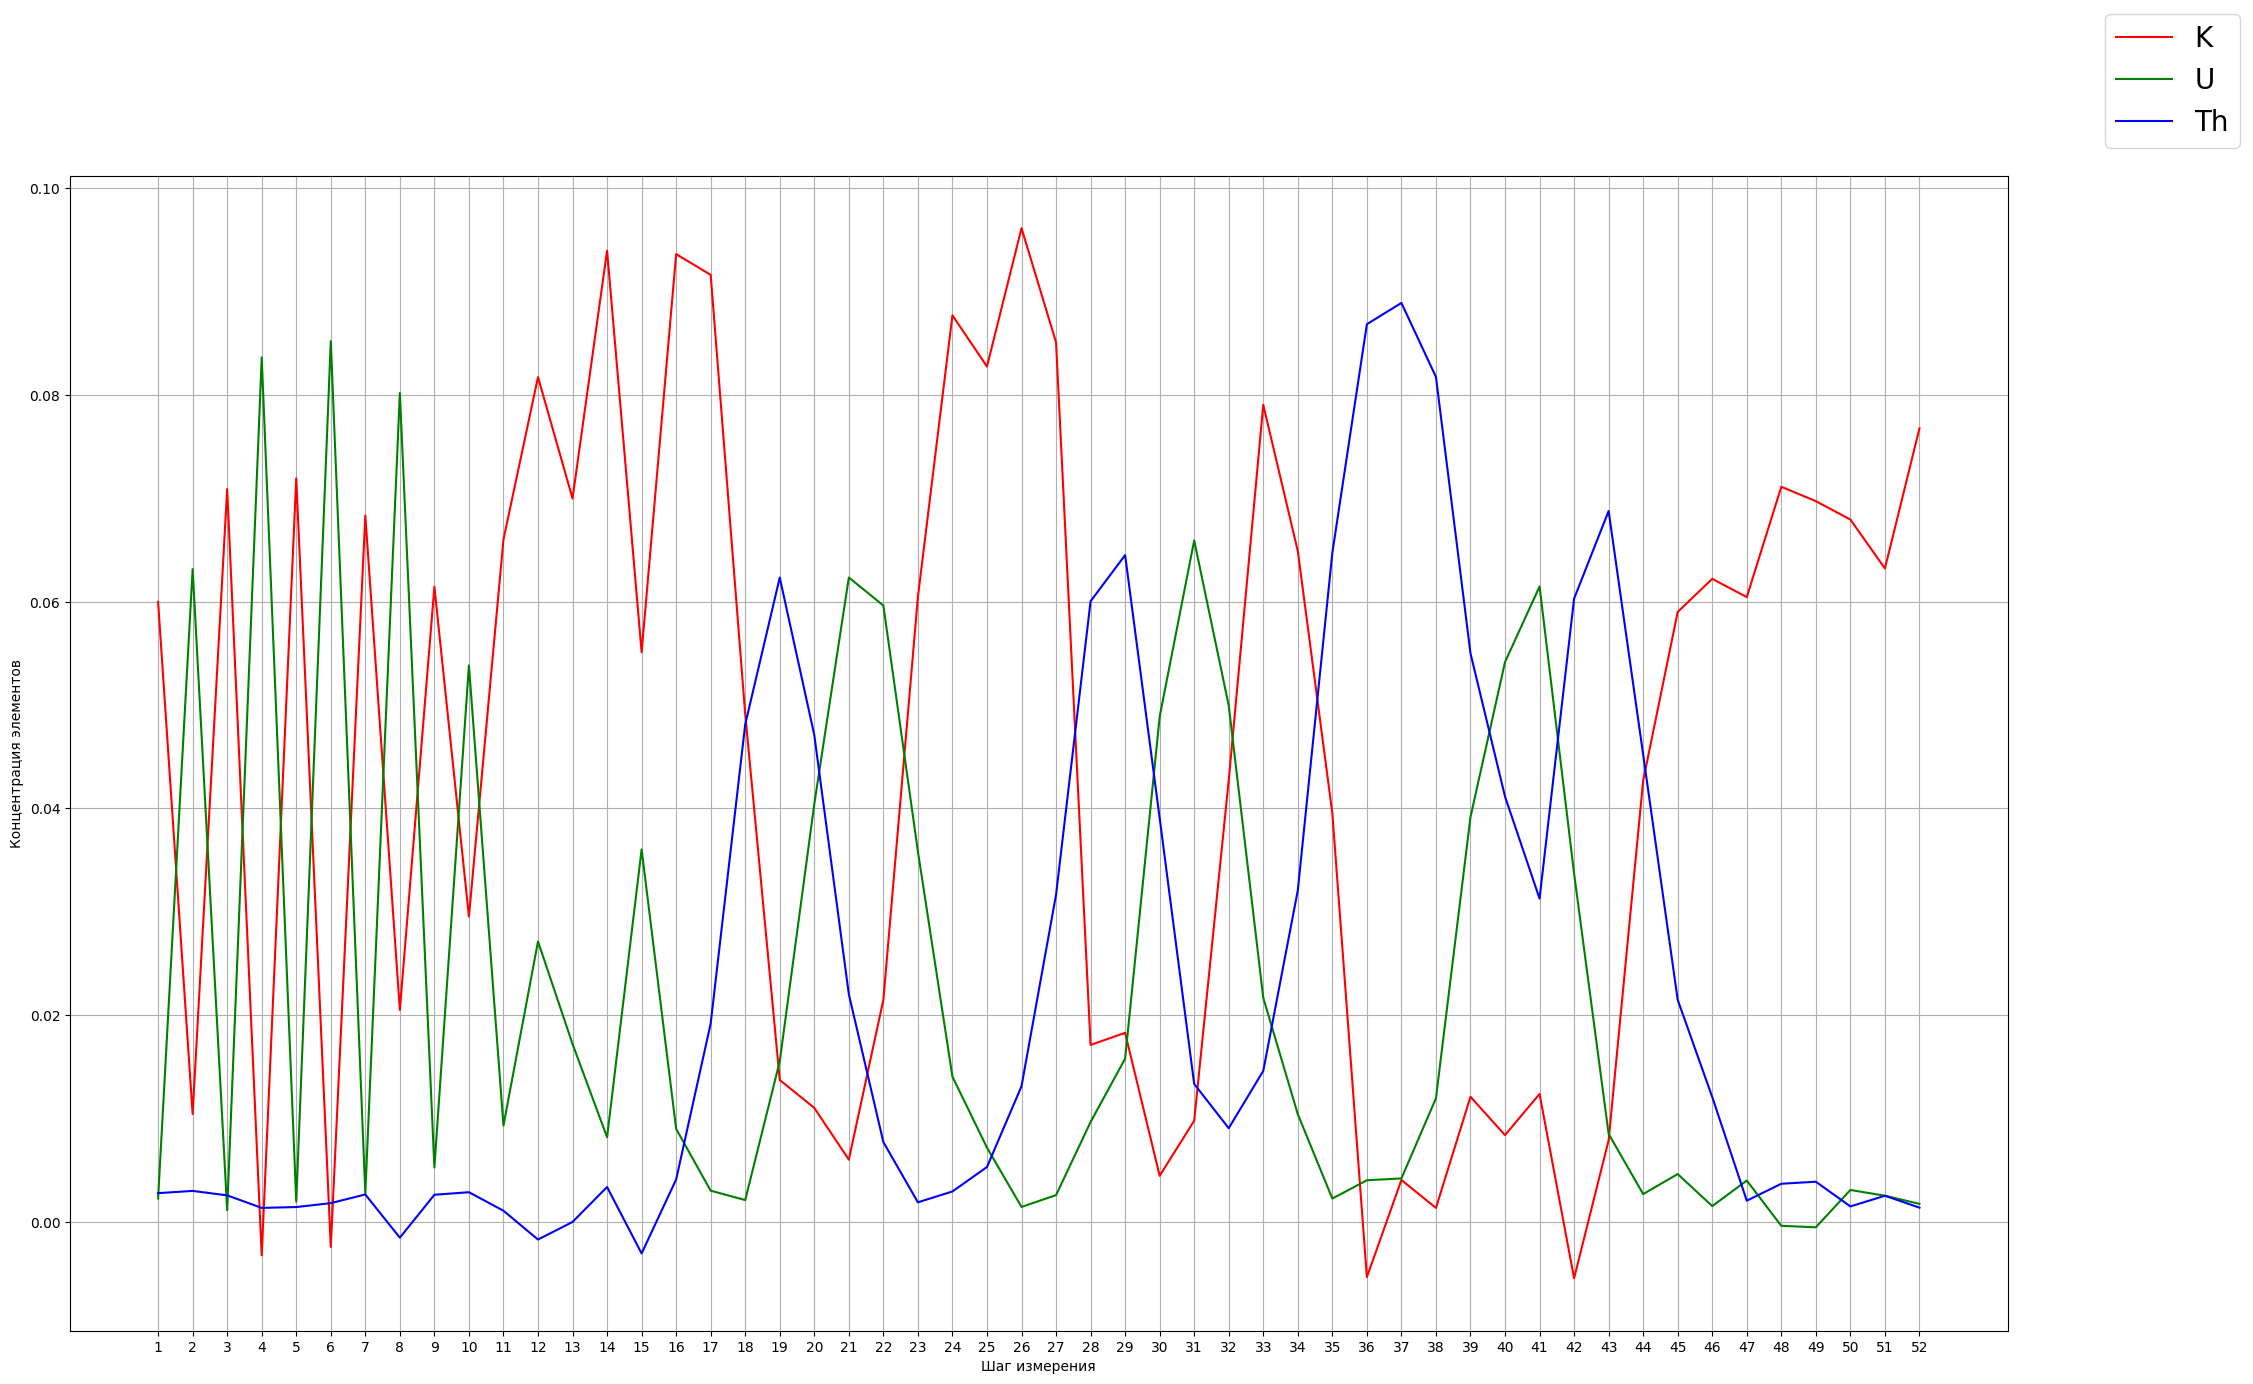

In [15]:
# Визуализируем концентрации, чтобы определить, какой элемент преобладал в образце при записи
samp = np.arange(1, 53, 1) # Массив для 52 записей

fig, ax = plt.subplots()
fig.set_size_inches(25,15) 

ax.plot(samp, conc[0], label = 'K', c = 'r')
ax.plot(samp, conc[1], label = 'U', c = 'g')
ax.plot(samp, conc[2], label = 'Th', c = 'b')
ax.set_xticks(range(1,53,1))

ax.set_xlabel('Шаг измерения')
ax.set_ylabel('Концентрация элементов')

fig.legend(fontsize = 20)

ax.grid()
